Amaç: Farklı mağazalarda yer alan, farklı ürünlerin 3 ay sonraki tahminlerini gerçekleştirmek.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
train = pd.read_csv("demand_forecasting/train.csv", parse_dates=["date"])
test = pd.read_csv("demand_forecasting/test.csv", parse_dates=["date"])

In [4]:
sample_sub = pd.read_csv("demand_forecasting/sample_submission.csv")

In [5]:
df = pd.concat([train,test],axis = 0,sort = False)
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


# EDA (Exploratory Data Analysis)

In [6]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [7]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [8]:
df[["date"]].max()

date   2018-03-31
dtype: datetime64[ns]

In [9]:
df[["store"]].nunique()

store    10
dtype: int64

In [10]:
df[["item"]].nunique()

item    50
dtype: int64

Mağaza ve ürün kırılımındaki eşsiz değer sayısına bakalım. Acaba her mağazada tüm ürünler satılıyor mu?

In [11]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
df.groupby(["store","item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [13]:
df.groupby(["store","item"]).agg({"sales": ["sum","mean","median","std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [14]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


# Feature Engineering

In [15]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [16]:
df = create_date_features(df)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [17]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

Overfitting olmaması için veriye gürültü ekliyoruz.

In [18]:
# Random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features

gürültülü verileri modele eklemeden önce zamana göre sıralı olması gerekiyor.

In [19]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


Burada amacımız daha önce gördüğümüz trend, mevsimsellik gibi featureleri makine öğrenmesi modelimize nasıl entegre ederiz. Bunu yapmak.

In [20]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [21]:
df.groupby(["store","item"])["sales"].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [22]:
df.groupby(["store","item"])["sales"].transform(lambda x: x.shift(1))    #bir değeri tahmin etmek için kendinden bir önceki değere bakılır.

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

Şimdi bu yaptığımızı belirli zaman periyotlarında verimize uygulayalım.

In [23]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [24]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [25]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.776093,54.843633,70.248350,67.342651,69.631451,79.541765,74.840190,59.703762,97.046123,75.677366
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,60.792681,51.500333,64.342753,58.466528,76.257783,79.221658,79.341631,72.990983,80.527734,67.965132
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.853858,62.936286,70.192635,63.808449,73.679835,87.265186,84.595170,67.275888,98.226159,73.735908
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,76.881214,75.383200,73.406181,68.089536,67.085858,82.392601,90.948632,67.025836,79.333936,82.714607


In [26]:
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

# Rolling Mean Features


In [27]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10], #kendisi de dahil yazan sayıda önceliğe git ve ortalama al demek.
              "roll3": df["sales"].rolling(window=3).mean().values[0:10], 
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [28]:

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})



,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


Şimdi bunu bir fonksiyona bağlayalım.

In [29]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [30]:
df = roll_mean_features(df, [365, 546])  # 1 ve 1.5 yıl öncesindeki ilişkiyi veriye yansıtıyorum.
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.776093,54.843633,70.248350,67.342651,69.631451,79.541765,74.840190,59.703762,97.046123,75.677366,88.430751,83.468843
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,60.792681,51.500333,64.342753,58.466528,76.257783,79.221658,79.341631,72.990983,80.527734,67.965132,84.519462,85.680284
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.853858,62.936286,70.192635,63.808449,73.679835,87.265186,84.595170,67.275888,98.226159,73.735908,88.497400,88.122211
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,76.881214,75.383200,73.406181,68.089536,67.085858,82.392601,90.948632,67.025836,79.333936,82.714607,88.076574,83.949020


# Exponentially Weighted Mean Features

In [31]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})



,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [32]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


In [33]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [34]:
df = ewm_features(df, alphas, lags)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.776093,54.843633,70.248350,67.342651,69.631451,79.541765,74.840190,59.703762,97.046123,75.677366,88.430751,83.468843,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,60.792681,51.500333,64.342753,58.466528,76.257783,79.221658,79.341631,72.990983,80.527734,67.965132,84.519462,85.680284,61.928089

# One-hot Encoding

In [35]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month"])
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,Fals

Çok fazla sütun oldu. Bu train süresini artırır. O yüzden bağımlı değişken logaritması (Log of dependent variable) yapalım.

# Bağımlı değişken logaritması (Log of dependent variable)
### İsteğe bağlıdır.
Converting sales to log(1+sales)


In [36]:
df["sales"] = np.log1p(df["sales"].values)

In [37]:
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,2.708050,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fals

In [38]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

Bir makine öğrenmesi modelinin başarısını ölçmek için mae,mse veya rmse gibi metrikler vardı. Burada ise metriğimiz smape

Model oluşturacağız. Fakat öncesinde verimizin train kısmından validasyon kısmını parçalayalım. Ama şöyle bir sorun var. Bizim train setimiz 2017 de bitiyor. Test setimiz ve bizden istenen tahmin ise 2018 den başlamalı. Bu durumda VALİDASYON setini 2018 e en yakın yani 2017 yılındaki veriler olarak parçalayalım. İyi bir model eğitimi için.

In [39]:
train = df.loc[(df["date"] < "2017-01-01"),:]

In [40]:
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"),:] # 2017 nin ilk 3 ayı

In [41]:
val

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1461,2017-01-01,2.995732,NaN,1,1,52,2017,1,1,0,26.379895,26.420059,29.621210,24.629415,25.865441,35.791916,31.761949,11.841094,30.346460,14.833265,26.067070,18.244921,25.945616,26.945124,26.600120,24.052691,30.392182,24.746346,13.392104,30.474469,14.106506,25.884810,26.880977,26.200950,24.111103,29.867830,24.490565,13.766633,30.895524,14.222089,25.755581,26.727186,25.408003,24.243376,29.066596,24.001580,14.449431,31.560936,14.457248,25.626387,26.540456,24.631135,24.388848,28.589323,23.584817,15.014059,31.960188,14.659810,25.336195,26.033001,23.224180,24.695000,28.493284,23.083219,15.615928,31.842915,14.803870,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
1462,2017-01-02,2.772589,NaN,2,2,1,2017,0,0,0,23.433461,18.350719,15.429211,22.560477,31.949326,16.077807,18.821679,14.389606,21.471446,14.046161,25.544794,22.901114,20.297281,17.497256,19.380006,24.002635,22.419609,18.337317,12.069605,20.523723,14.005325,20.588481,17.988098,19.720095,24.011110,22.786783,18.649056,12.176663,21.089552,14.022209,21.151116,18.945437,20.281601,24.048675,23.413319,19.200316,12.489886,22.312187,14.091450,21.687916,19.862137,20.689341,24.116654,23.976797,19.675445,12.904218,23.588056,14.197943,22.668098,21.516501,21.112090,24.347500,25.246642,20.541610,13.807964,25.921458,14.401935,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [42]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [43]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [44]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

Şimdi modelimizi oluşturalım.

# LightGBM ile Zaman Serisi Modeli

In [45]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'nthread': -1}

early_stopping_callback = lgb.early_stopping(stopping_rounds= 200)
log_evaluation_callback = lgb.log_evaluation(100)

In [46]:
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs


# Normal makine öğrenmesi algoritmaları ile lgb alogritması arasındaki farklar.

lgb modelini geliştirenler kemdilerine özgü bir veri modeli geliştirmişler ve eğer kendi modelimizi lgb üzerinden oluşturmak istiyorsak elimizdeki verisetimizi bu veri modeline göre transform etmemiz lazım.

In [47]:
lgbtrain = lgb.Dataset(data = X_train, label= Y_train, feature_name= cols)
lgbval = lgb.Dataset(data = X_val, label= Y_val, reference= lgbtrain ,feature_name= cols)

In [48]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[early_stopping_callback, log_evaluation_callback],
                  feval=lgbm_smape)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513445	training's SMAPE: 17.5884	valid_1's l2: 0.0530268	valid_1's SMAPE: 17.4505
[200]	training's l2: 0.0352173	training's SMAPE: 14.5573	valid_1's l2: 0.0370161	valid_1's SMAPE: 14.89
[300]	training's l2: 0.0324287	training's SMAPE: 14.0038	valid_1's l2: 0.0340763	valid_1's SMAPE: 14.4252
[400]	training's l2: 0.0313841	training's SMAPE: 13.7931	valid_1's l2: 0.0332634	valid_1's SMAPE: 14.28
[500]	training's l2: 0.0307164	training's SMAPE: 13.6615	valid_1's l2: 0.0326907	valid_1's SMAPE: 14.1547
[600]	training's l2: 0.0302386	training's SMAPE: 13.5674	valid_1's l2: 0.0322648	valid_1's SMAPE: 14.0552
[700]	training's l2: 0.0299059	training's SMAPE: 13.4989	valid_1's l2: 0.0319116	valid_1's SMAPE: 13.9736
[800]	training's l2: 0.0296266	training's SMAPE: 13.4438	valid_1's l2: 0.031672	valid_1's SMAPE: 13.9171
[900]	training's l2: 0.0293745	training's SMAPE: 13.3964	valid_1's l2: 0.0315076	valid_1's SMAP

In [49]:
y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)
y_pred_val

array([2.89208533, 2.62668842, 2.72281298, ..., 4.28256647, 4.36676001,
       4.43046073])

In [50]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))  # yukarıda model oluşturmadan önce sales değişkeninin logaritmasını almıştık.
                                              # Burada ise geri dönerek orijinal haline getiriyoruz.

13.839418882123068

Model oluşturduk ama en iyi parametreleri, en iyi değişkenleri de seçip son kez optimize edilmiş şekilde modelimizi oluşturalım.

In [51]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

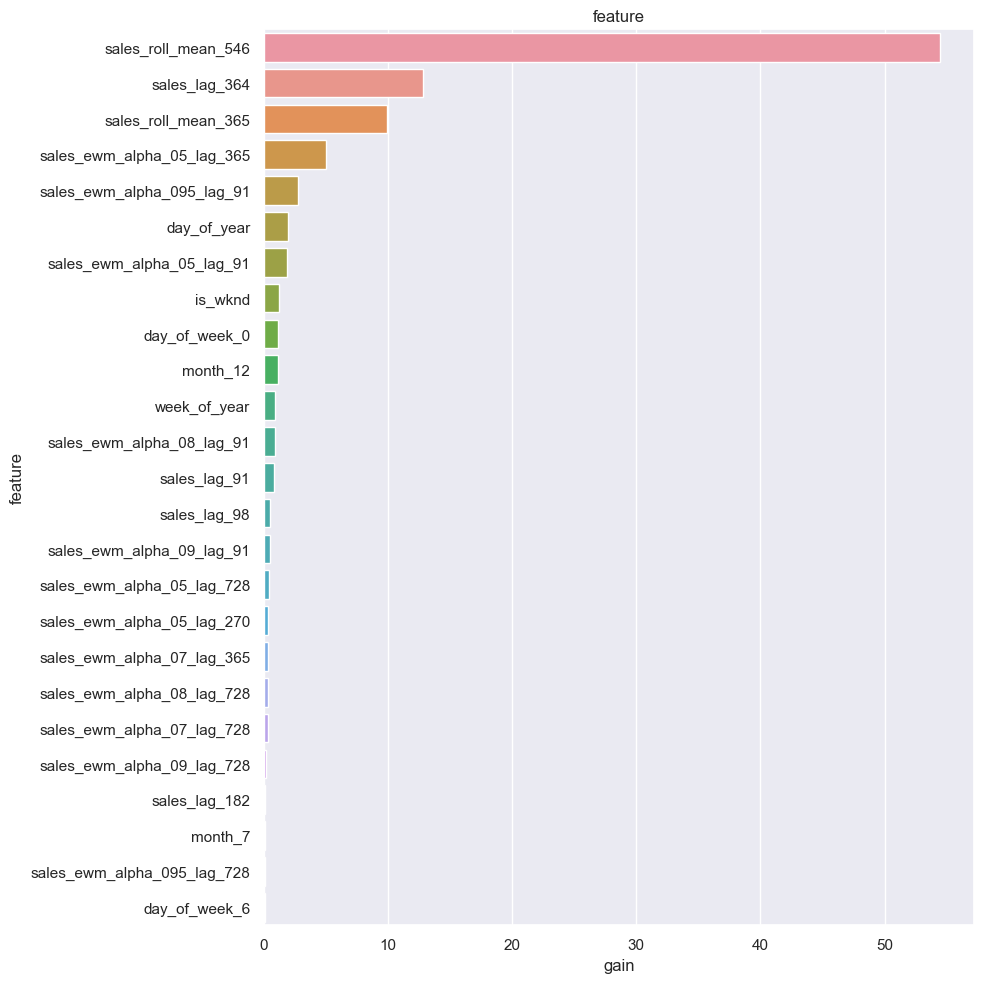

,feature,split,gain
17,sales_roll_mean_546,931,54.480218
13,sales_lag_364,1238,12.881427
16,sales_roll_mean_365,636,9.968545
60,sales_ewm_alpha_05_lag_365,355,5.017421
18,sales_ewm_alpha_095_lag_91,103,2.765023
...,...,...,...
111,item_39,0,0.000000
74,item_2,0,0.000000
86,item_14,0,0.000000
115,item_43,0,0.000000


In [52]:
plot_lgb_importances(model, num=30, plot=True)

Son kez model oluşturalım. Veriyi parçalamamıza gerek kalmadan

In [53]:
train = df.loc[~df.sales.isna()]
Y_train = train["sales"]
X_train = train[cols]

In [54]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [55]:
feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                        feature  split       gain
17          sales_roll_mean_546    931  54.480218
13                sales_lag_364   1238  12.881427
16          sales_roll_mean_365    636   9.968545
60   sales_ewm_alpha_05_lag_365    355   5.017421
18   sales_ewm_alpha_095_lag_91    103   2.765023
..                          ...    ...        ...
111                     item_39      0   0.000000
74                       item_2      0   0.000000
86                      item_14      0   0.000000
115                     item_43      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


113

In [56]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [57]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

In [58]:
test_preds = final_model.predict(X_test, num_iteration = model.best_iteration)
test_preds

array([2.63324644, 2.67455772, 2.65520542, ..., 4.36762721, 4.40453133,
       4.48800577])

In [59]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,10.502302,14.635494,19.810780,13.579088,11.824678,16.485776,17.988655,18.085357,19.292469,10.495378,25.846090,21.845069,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,16.749720,17.448225,21.351022,21.002131,26.066151,18.844151,21.958463,9.039065,30.231338,11.210935,24.388233,20.072024,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [62]:
submission_df = test.loc[:,["id","sales"]]
submission_df["sales"] = np.expm1(test_preds)
submission_df["id"] = submission_df.id.astype(int)
submission_df

,id,sales
0,0,12.918883
1,1,13.505933
2,2,13.227908
3,3,16.056023
4,4,16.614346
...,...,...
44995,44995,69.159512
44996,44996,74.625066
44997,44997,77.856300
44998,44998,80.820787


In [63]:
submission_df.to_csv("submission_demand.csv", index= False)    #yaptığım tahminleri bir csv dosyasına atıyorum.